In [1]:
# pip install pandas
import pandas as pd
import numpy as np

## step 1.1 - loading the historical data

In [2]:
folder = r'M:\DEV\github__a_moscatelli\repositories\home\am-wiki-assets\equityaccumulator'+'\\'

hist_csv_filename = folder + 'JPM.csv'
summary = {}
verbose = False
charting = True

*functions*

In [3]:
def load_past(hist_csv_filename):
    histcolname='Date'
    filedateformat='%Y-%m-%d'
    #yh = pd.read_csv(hist_csv_filename)
    yh = pd.read_csv(
                    hist_csv_filename,
                    #parse_dates=[histcolname],
                    #date_parser=lambda x: datetime.strptime(x,filedateformat),
                    index_col=histcolname)
    yh = yh.rename(columns={'Adj Close': 'AdjClose'})
    return yh

In [4]:
def print_summary():
    # https://stackoverflow.com/questions/18193205/list-comprehension-returning-values-plus-none-none-none-why
    devnull=[ print(kk,'=>',summary[kk]) for kk in summary.keys()] 

*execution*

In [5]:
yhz=load_past(hist_csv_filename)
yhz

,Open,High,Low,Close,AdjClose,Volume
Date,,,,,,
2022-05-31,130.179993,133.149994,129.710007,132.229996,127.951584,17015000
2022-06-01,132.869995,132.869995,128.669998,129.910004,125.706657,10768000
2022-06-02,129.899994,132.009995,128.669998,132.000000,127.729042,8374800
2022-06-03,131.210007,131.770004,129.990005,130.160004,125.948578,8596000
2022-06-06,131.089996,132.389999,129.460007,129.729996,125.532494,11323500
...,...,...,...,...,...,...
2023-05-22,141.000000,141.639999,137.660004,138.029999,138.029999,11402500
2023-05-23,137.539993,139.029999,136.460007,136.589996,136.589996,9514900
2023-05-24,135.399994,136.350006,135.080002,135.339996,135.339996,8578000


In [6]:
summary['hist_filename']=hist_csv_filename
summary['hist_shape']=yhz.shape
summary['hist_firstdt']=yhz.index[0]
summary['hist_lastdt']=yhz.index[-1]

## step 1.2 - profiling the historical data

*functions*

In [7]:
def add_columns(df,AdjClose):
    #AdjClose='AdjClose'
    df['LagAdjClose'] = df[AdjClose].shift(1)
    df['DailyLogRet'] = np.log(df[AdjClose]/df['LagAdjClose'])
    return df

def getstats(df,DailyLogRet):
    sigma = df[DailyLogRet].std()
    mu = df[DailyLogRet].mean()
    cnt = df[DailyLogRet].count()
    return {'sigma':sigma,'mu':mu,'dretCount':cnt}


*execution*

In [8]:
yh=add_columns(yhz,'AdjClose')

In [9]:
yh.DailyLogRet.describe()

count    249.000000
mean       0.000273
std        0.017309
min       -0.055657
25%       -0.010019
50%        0.000264
75%        0.009317
max        0.072795
Name: DailyLogRet, dtype: float64

In [10]:
yhs = getstats(yh,'DailyLogRet')
summary['hist_stats'] = yhs
yhs

{'sigma': 0.017308744241388962, 'mu': 0.0002726544013365923, 'dretCount': 249}

## step 1.3 - computing the future price paths

*functions*

In [11]:
import matplotlib.pyplot as plt
#from scipy.stats import norm
import math

In [12]:
from datetime import datetime

In [13]:
# source: https://en.wikipedia.org/wiki/Geometric_Brownian_motion#Simulating_sample_paths

def get_futpath(drift,vol,n,lastclose):
    dt = 0.1
    x0 = lastclose
    #n = 252
    mu = drift
    sigma = vol
    sz=1
    x = np.exp(
        (mu - sigma ** 2 / 2) * dt
        +
        sigma * np.random.normal(0, np.sqrt(dt), size=(sz, n)).T
    )

    x = np.vstack([np.ones(sz), x])
    x = x0 * x.cumprod(axis=0)
    rp = x[:,0]
    df = pd.DataFrame({'AdjClose':rp},index=None) # , index=rows, columns=columns) # was px
    df=add_columns(df,'AdjClose')  # was px
    ss=getstats(df,'DailyLogRet')
    if verbose: print('path stats:',ss)
    delete_the_first = True # the first is the last of the provided historical prices
    xfut = rp
    assert len(xfut) == n+1
    
    if delete_the_first:
        xfut = np.delete(rp, 0) # xfut[0] is going to be = xpast[-1], hence this removal.    
    assert len(xfut) == n
    return xfut # rp

    #math.sqrt(250)

*execution*

In [14]:
random_seed = 1 
np.random.seed(random_seed)

In [15]:
rpath = []
fullpath = []

noPaths = 252 # *2   # 1000
futprices = 252

summary['paths'] = noPaths
summary['hist_lastclose'] = yh.AdjClose.iloc[-1]

print('hist profile:',yhs)
lastclose = yh.AdjClose.iloc[-1]
summary['futprices'] = futprices
summary['exec_start_rand'] = datetime.now()
for ipath in range(noPaths):
    #print('ipath:',ipath)
    xpath=get_futpath(yhs['mu'],yhs['sigma'],futprices,lastclose)
    rpath.append(xpath)


hist profile: {'sigma': 0.017308744241388962, 'mu': 0.0002726544013365923, 'dretCount': 249}


In [16]:
xpast = yh.AdjClose.values # = yh.AdjClose.to_numpy()
# building the hist+fut paths = the inputs of the pricer
for ipath in range(noPaths):
    xfut = rpath[ipath]
    full = np.concatenate([xpast,xfut])
    fullpath.append(full)


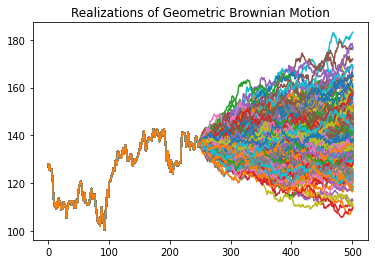

In [17]:
if True:
    for ipath in range(noPaths):
        plt.plot(fullpath[ipath])
        plt.title("Realizations of Geometric Brownian Motion")
    #plt.show()

## step 2.1 - loading pricing specs

In [18]:
import yaml  # pip install pyyaml
from datetime import datetime, timedelta

*functions*

In [19]:
def load_contract_spec(contract):
    with open(contract, 'r') as file:
        contract_spec = yaml.safe_load(file)
        if False:
            contract_spec['dates']['startdate'] = datetime.strptime(contract_spec['dates']['startdate'],   contract_spec['dates']['dateformat'])
            contract_spec['dates']['enddate']   = datetime.strptime(contract_spec['dates']['enddate'],     contract_spec['dates']['dateformat'])
        # 2022-07-08
            del contract_spec['dates']['dateformat']
        #print(contract_spec)
        return contract_spec


*execution*

In [20]:
contract = 'contract.yml'
contract_spec = load_contract_spec(folder + contract)
summary['contract_specs']='contract.yml'
summary['exec_start_simul'] = datetime.now()

## step 2.2 - prescriptive and pricing loop

In [21]:
import math

In [22]:
import statistics

*functions*

In [23]:
class Hdf:
    df = None
    def _dbg(self,trace):
        print('count of dates after','<'+trace+'>',':',self.df.shape[0])
    #def __init__(self):
        #self._dbg('init')
    
    def load_df(self,df):
        self.df = df
        
    def load_csv(self, hist_csv_filename,histcolname,filedateformat):
        self.df = pd.read_csv(
                    hist_csv_filename,
                    parse_dates=[histcolname],
                    date_parser=lambda x: datetime.strptime(x,filedateformat),
                    index_col=histcolname)
        self._dbg('init')
        # https://www.dataquest.io/blog/tutorial-time-series-analysis-with-pandas/ follows the same steps
        False and print(self.df.dtypes)

    def withSignal(self,colname,lambdasignal,activation):
        assert False
        assert activation in ['up','down']
        self.df[colname] = self.df.apply(lambda row: lambdasignal(row), axis=1).copy()
        fdf = self.df[self.df[colname]]
        if fdf.shape[0]>=0:
            activation_index = fdf.index[0]
            print('activation_index',activation_index)
            if activation=='up':
                self.df[colname] = self.df.apply(lambda row: row.name >= activation_index, axis=1).copy()
            if activation=='down':
                self.df[colname] = self.df.apply(lambda row: row.name <= activation_index, axis=1).copy()
        self._dbg(colname)
        return self

In [24]:
def hist(field,date,dayoffset,hdf):
    #global hdf
    # historical data lookup - relative to T
    assert dayoffset <= 0
    # date is str
    #date_ = datetime.strptime(date,"%Y-%m-%d")
    #date2 = date + timedelta(days=dayoffset)	# may not be included in the df
    #print('hist:',date,field,dayoffset,date2)
    ret = hdf.df.shift(dayoffset).at[date,field]
    #print('shifted hist:',hdf.df.shift(dayoffset).loc[date])
    #ret = hdf.df.at[date2,field]
    #print('ret:',ret)
    if not ret: ret=0
    return ret


In [25]:
#lastdate=yh.index[-1]
#lastdt=datetime.strptime(lastdate,"%Y-%m-%d")


def getnextdt(lastdt,considerPublicHolidays, useStrings):
    assert not considerPublicHolidays
    if useStrings:
        lastdt=datetime.strptime(lastdt,"%Y-%m-%d")
    dow_eur=lastdt.strftime("%a")
    #print(lastdt,dow_eur)
    offset=1
    if dow_eur=='Fri': offset=3
    if dow_eur=='Sat': offset=2
    
    lastdt = lastdt + timedelta(days=offset)
    if useStrings:
        return datetime.strftime(lastdt,"%Y-%m-%d")
    else:
        return lastdt




In [26]:
def get_future_dates(lastdate,path):
    futdt = []
    curdt=lastdate
    futpathx=rpath[path]
    for px in futpathx:
        curdt=getnextdt(curdt,False,True)
        futdt.append(curdt)
        #print(px)
        #pass
    assert len(futdt) == len(rpath[path])
    return futdt

In [27]:
def compute1_noncumul(hdf,contract_spec):
    
    #print(contract_spec['dates']['startdate'], contract_spec['dates']['enddate'])
    hdf.df['live'] = hdf.df.apply(lambda row:  contract_spec['dates']['startdate'] <= row.name <= contract_spec['dates']['enddate'], axis=1)
    hdf.df['KI'] = hdf.df.apply(lambda row:  row.live and eval(contract_spec['knock-in'],{'row':row}), axis=1).cummax()
    # the input of cummax is a df column having true when the KI condition is met. cummax() keeps confirming True in the future once met. cummax = carryover of True.
    hdf.df['KO'] = hdf.df.apply(lambda row:  row.KI and eval(contract_spec['knock-out'],{'row':row}), axis=1).cummax()
    hdf.df['accumulation'] = hdf.df['KI'] & ~hdf.df['KO']
    # bitwise is inside the KI zone and not inside the KO zone
    return hdf




In [28]:
def compute2_cumul(hdf,contract_spec):

    hdf.df.insert(0, 'SN', range(0, 0 + len(hdf.df)))

    hdf.df['BQty']  = hdf.df.apply(lambda row: row.accumulation and eval(contract_spec['buy']['qty'],  {'row':row, 'math':math,'hist':hist,'H':hdf,'T':row.name,'BQ':BQ,'SQ':SQ}), axis=1)
    hdf.df['BAt']   = hdf.df.apply(lambda row: row.accumulation and eval(contract_spec['buy']['at'],   {'row':row, 'math':math,'hist':hist,'H':hdf,'T':row.name}), axis=1)
    hdf.df['BWhen'] = hdf.df.apply(lambda row: row.accumulation and eval(contract_spec['buy']['when'], {'row':row, 'math':math,'hist':hist,'H':hdf,'T':row.name}), axis=1)
    hdf.df['SQty']  = hdf.df.apply(lambda row: row.accumulation and eval(contract_spec['sell']['qty'], {'row':row, 'math':math,'hist':hist,'H':hdf,'T':row.name,'BQ':BQ,'SQ':SQ}), axis=1)
    hdf.df['SAt']   = hdf.df.apply(lambda row: row.accumulation and eval(contract_spec['sell']['at'],  {'row':row, 'math':math,'hist':hist,'H':hdf,'T':row.name}), axis=1)
    hdf.df['SWhen'] = hdf.df.apply(lambda row: row.accumulation and eval(contract_spec['sell']['when'],{'row':row, 'math':math,'hist':hist,'H':hdf,'T':row.name}), axis=1)
    #cashflow
    hdf.df['BCF']   = hdf.df.apply(lambda row: row.accumulation and row.BWhen and - (row.BQty * row.BAt),axis=1)
    hdf.df['SCF']   = hdf.df.apply(lambda row: row.accumulation and row.SWhen and + (row.SQty * row.SAt),axis=1)
    #cumul
    hdf.df['CumQty']= hdf.df.apply(lambda row: row.BWhen and row.BQty - row.SWhen and row.SQty , axis=1).cumsum()
    hdf.df['CumCF'] = hdf.df.apply(lambda row: row.BCF + row.SCF, axis=1).cumsum()
    return hdf



In [29]:
def get_lastCumCF_array():
    lastCumCF_array = []
    for ipath in range(noPaths):
        #plt.plot(fullpath[ipath])
        #plt.title("Realizations of Geometric Brownian Motion")
        #plt.show()

        rpathx=rpath[ipath]
        if verbose: print('min/max/avg path px',min(rpathx),max(rpathx),statistics.mean(rpathx))
        futdf = pd.DataFrame({'AdjClose':rpathx},index=futdt)
        fulldf = pd.concat([yh,futdf])

        # simulate accumulation
        #del hdf0
        hdf0 = Hdf()
        hdf0.load_df(fulldf)
        hdf = compute1_noncumul(hdf0,contract_spec)
        accumulation_occurs = hdf.df.loc[hdf.df.accumulation].shape[0] > 0
        
        if accumulation_occurs:
            acc_a = hdf.df.loc[hdf.df.accumulation].head(1).index.values[0]
            acc_z = hdf.df.loc[hdf.df.accumulation].tail(1).index.values[0]
            if verbose: print('Accumulation','begins on:',acc_a,'ends on',acc_z) # .loc[hdf.df['accumulation']==True].idxmin())
            # .loc[hdf.df.accumulation==True].idxmax())
        else:
            if verbose: print('Accumulation begins/ends: NEVER')

        hdf = compute2_cumul(hdf,contract_spec)
        # hdf.df
        lastCumCF=hdf.df["CumCF"].iloc[-1]
        avgCumCF=hdf.df["CumCF"].mean()
        if verbose: print('ipath',ipath,'CumCF',lastCumCF,'avgCumCF',avgCumCF)
        lastCumCF_array.append(lastCumCF)

        if False:
            plt.plot(hdf.df["CumCF"]) #, df["Y"])
            plt.show()
    return lastCumCF_array

*execution*

In [30]:
assert max(True,False)==True and min(True,False)==False
# ... as a verification of any platform-dependent logic

lastdate=yh.index[-1]
futdt = get_future_dates(lastdate,0)
summary['fut_firstdt'] = futdt[0]
summary['fut_lastdt'] = futdt[-1]

In [31]:
print_summary()

hist_filename => M:\DEV\github__a_moscatelli\repositories\home\am-wiki-assets\equityaccumulator\JPM.csv
hist_shape => (250, 6)
hist_firstdt => 2022-05-31
hist_lastdt => 2023-05-26
hist_stats => {'sigma': 0.017308744241388962, 'mu': 0.0002726544013365923, 'dretCount': 249}
paths => 252
hist_lastclose => 136.940002
futprices => 252
exec_start_rand => 2023-09-05 11:48:22.049632
contract_specs => contract.yml
exec_start_simul => 2023-09-05 11:48:23.954958
fut_firstdt => 2023-05-29
fut_lastdt => 2024-05-14


In [32]:
prsdata = pd.DataFrame(None, columns = ["BQ", "SQ","P_Loss","MaxCumCF","MinCumCF"], index=None)
sample_histog_data = None
for prs in range(20):
    BQ = np.random.randint(1, 10) # (inclusive,exclusive)
    SQ = np.random.randint(1, 10) # (inclusive,exclusive)
    print('going to start pricing '+str(noPaths)+' paths with prescriptive scenario',prs,'BQ/SQ',(BQ,SQ),'time:',datetime.now().strftime('%Y-%m-%d-%H:%M:%S'))
    # MAP
    lastCumCF_array = get_lastCumCF_array()
    # REDUCE
    sample_histog_data = lastCumCF_array
    Ploss = len(list(filter(lambda cumcf: cumcf < 0, lastCumCF_array))) / len(lastCumCF_array)
    max_lastCumCF_array = max(lastCumCF_array)
    min_lastCumCF_array = min(lastCumCF_array)
    prsdata.loc[len(prsdata)] = [BQ, SQ, Ploss, max_lastCumCF_array, min_lastCumCF_array]

going to start pricing 252 paths with prescriptive scenario 0 BQ/SQ (2, 4) time: 2023-09-05-11:48:24
going to start pricing 252 paths with prescriptive scenario 1 BQ/SQ (9, 5) time: 2023-09-05-11:49:36
going to start pricing 252 paths with prescriptive scenario 2 BQ/SQ (3, 9) time: 2023-09-05-11:50:53
going to start pricing 252 paths with prescriptive scenario 3 BQ/SQ (7, 4) time: 2023-09-05-11:52:03
going to start pricing 252 paths with prescriptive scenario 4 BQ/SQ (2, 3) time: 2023-09-05-11:53:13
going to start pricing 252 paths with prescriptive scenario 5 BQ/SQ (1, 7) time: 2023-09-05-11:54:24
going to start pricing 252 paths with prescriptive scenario 6 BQ/SQ (9, 2) time: 2023-09-05-11:55:35
going to start pricing 252 paths with prescriptive scenario 7 BQ/SQ (5, 8) time: 2023-09-05-11:56:46
going to start pricing 252 paths with prescriptive scenario 8 BQ/SQ (8, 9) time: 2023-09-05-11:57:57
going to start pricing 252 paths with prescriptive scenario 9 BQ/SQ (8, 7) time: 2023-09-05

In [33]:
summary['exec_end'] = datetime.now()

In [34]:
if False:
    plt.hist(sample_histog_data, density=True, bins=30)
    plt.title("Distribution of Accounting P/L "+str(prs))
    None # to prevent non-required output

In [35]:
print_summary()

hist_filename => M:\DEV\github__a_moscatelli\repositories\home\am-wiki-assets\equityaccumulator\JPM.csv
hist_shape => (250, 6)
hist_firstdt => 2022-05-31
hist_lastdt => 2023-05-26
hist_stats => {'sigma': 0.017308744241388962, 'mu': 0.0002726544013365923, 'dretCount': 249}
paths => 252
hist_lastclose => 136.940002
futprices => 252
exec_start_rand => 2023-09-05 11:48:22.049632
contract_specs => contract.yml
exec_start_simul => 2023-09-05 11:48:23.954958
fut_firstdt => 2023-05-29
fut_lastdt => 2024-05-14
exec_end => 2023-09-05 12:13:04.989987


In [36]:
import json
devnull = contract_spec.pop('offline',None)
#ie print the contract specs excluding the 'offline' key
print(json.dumps(contract_spec, indent=4))

{
    "contract": "CC1",
    "file": "jpm.csv",
    "market": "NYSE",
    "desc": "first cocoa. t = date of last close",
    "knock-in": "row.AdjClose > 145",
    "knock-out": "row.AdjClose <= 120",
    "dates": {
        "startdate": "2022-06-02",
        "enddate": "2024-05-22",
        "dateformat": "%Y-%m-%d",
        "filedateformat": "%Y-%m-%d"
    },
    "comments": "can use min, max, avg, abs, math.ceil(), ...",
    "missing": "forward linear",
    "buy": {
        "qty": "BQ",
        "at": "hist('AdjClose',T,0,H)",
        "when": "hist('AdjClose',T,0,H) > hist('AdjClose',T,-1,H)"
    },
    "sell": {
        "qty": "SQ",
        "at": "hist('AdjClose',T,0,H)",
        "when": "hist('AdjClose',T,0,H) < hist('AdjClose',T,-1,H)",
        "desc": "if 2% up or more, sell"
    }
}


In [37]:
prsdata

,BQ,SQ,P_Loss,MaxCumCF,MinCumCF
0,2.0,4.0,0.000000,50121.170219,0.000000
1,9.0,5.0,0.535714,2748.737467,-85903.633487
2,3.0,9.0,0.000000,132204.524247,0.000000
3,7.0,4.0,0.535714,2457.155996,-65206.350738
4,2.0,3.0,0.019841,31113.580580,-2010.434897
5,1.0,7.0,0.000000,120098.533306,0.000000
6,9.0,2.0,0.543651,873.607231,-129308.466805
7,5.0,8.0,0.011905,87287.746269,-3055.383862
8,8.0,9.0,0.107143,67431.553401,-19865.959868
9,8.0,7.0,0.392857,29416.374122,-43441.160708


## contract parameters (Buyqty,SellQty) that resulted in the lowest Probability of Loss

In [38]:
print(prsdata[prsdata.P_Loss == prsdata.P_Loss.min()])

     BQ   SQ  P_Loss       MaxCumCF  MinCumCF
0   2.0  4.0     0.0   50121.170219       0.0
2   3.0  9.0     0.0  132204.524247       0.0
5   1.0  7.0     0.0  120098.533306       0.0
15  3.0  7.0     0.0   94189.344968       0.0
16  3.0  9.0     0.0  132204.524247       0.0


### summary plot

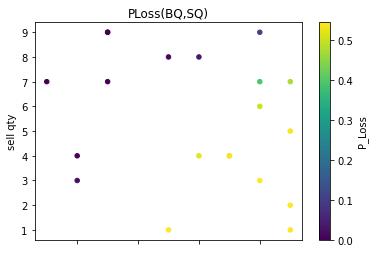

In [47]:
ax = prsdata.plot(kind='scatter',x='BQ',y='SQ',c='P_Loss',title='PLoss(BQ,SQ)')
ax.set(xlabel="buy qty", ylabel="sell qty")
None

## END